In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from src.mechanism_base import get_fourier_basis, get_fourier_basis_unstd, normalize_to_pi

def gradient_update(theta, xi, init_k, p, device):
    # Compute Fourier coefficients for theta and xi
    fourier_basis, _ = get_fourier_basis(p, device)
    # Ensure that the fourier_basis has the same dtype as theta and xi
    fourier_basis = fourier_basis.to(theta.dtype)
    theta_coeff = fourier_basis @ theta  
    xi_coeff    = fourier_basis @ xi

    # --- For theta: extract the 2-coefficient vector for neuron 'init_k'
    # Using list indexing to extract two rows from theta_coeff.
    neuron_coeff_theta = theta_coeff[[init_k * 2 - 1, init_k * 2]]
    alpha = np.sqrt(2/p) * torch.sqrt(torch.sum(neuron_coeff_theta.pow(2))).item()
    phi = np.arctan2(-neuron_coeff_theta[1].item(), neuron_coeff_theta[0].item())
    # print(alpha)
    # print(phi)

    # --- For xi: similarly, extract a 2-element vector (correcting psi_coeff -> xi_coeff)
    neuron_coeff_xi = xi_coeff[[init_k * 2 - 1, init_k * 2]]
    beta = np.sqrt(2/p) * torch.sqrt(torch.sum(neuron_coeff_xi.pow(2))).item()
    psi = np.arctan2(-neuron_coeff_xi[1].item(), neuron_coeff_xi[0].item())

    # --- Compute gradients over the p Fourier modes.
    w_k = 2 * np.pi * init_k / p
    grad_theta = torch.tensor(
        [2 * p * alpha * beta * np.cos(w_k * j + psi - phi) for j in range(p)],
        device=device
    )
    grad_xi = torch.tensor(
        [p * alpha**2 * np.cos(w_k * j + 2 * phi) for j in range(p)],
        device=device
    )

    return grad_theta, grad_xi

def simulate_gradient_flow(theta, xi, init_k, p, num_steps, learning_rate, device):
    # Lists to store the history (optional)
    theta_history = [theta.clone()]
    xi_history = [xi.clone()]
    
    for step in range(num_steps):
        grad_theta, grad_xi = gradient_update(theta, xi, init_k, p, device)
        # Update parameters using a simple Euler update (gradient descent style)
        theta = theta + learning_rate * grad_theta
        xi = xi + learning_rate * grad_xi
        
        theta_history.append(theta.clone())
        xi_history.append(xi.clone())
        
    return theta_history, xi_history

In [2]:
# --- Simulation parameters
device = torch.device("cpu")
p = 23              # number of Fourier modes / parameter size
init_k = 1          # chosen neuron index (adjust indexing as necessary)
num_steps = 16000 #16000 #5000     # number of gradient flow steps
learning_rate = 0.005

# init_phi = 0.88
# init_psi = 0.66

# init_phi = 1.14
# init_psi = 2.58

init_phi = 1.5
init_psi = 0

fourier_basis, _ = get_fourier_basis(p, device)

# Initialize theta and xi.
# Here we assume that each neuron is represented by 2 rows,
# so we use shape (2*p, p). Adjust if your parameters have a different shape.
w_k = 2 * np.pi * init_k / p
theta = 0.001 * torch.tensor([np.cos(w_k * j + init_phi) for j in range(p)], device=device)
xi = 0.001  * torch.tensor([np.cos(w_k * j + init_psi) for j in range(p)], device=device)
fourier_basis = fourier_basis.to(theta.dtype)

# Run the gradient flow simulation
theta_history, xi_history = simulate_gradient_flow(theta, xi, init_k, p, num_steps, learning_rate, device)


# === Full pipeline: compute histories and plot ===
# Assumes the following are defined:
# - theta_history: list of torch.Tensor
# - xi_history:    list of torch.Tensor
# - fourier_basis: torch.Tensor or numpy array
# - init_k:        integer (1-based neuron index)
# - p:             integer (total number of Fourier coefficients)
# - normalize_to_pi: function mapping a float to [-π, π]

# Pre-compute scaling factor
factor = np.sqrt(2/p)

# Allocate lists for histories
alphas, phis, betas, psis, deltas, g_2ks = [], [], [], [], [], []

# Loop through entire history
for theta, xi in zip(theta_history, xi_history):
    theta_coeff = fourier_basis @ theta
    xi_coeff    = fourier_basis @ xi
    
    # Extract the two Fourier rows for the neuron
    idx = [init_k * 2 - 1, init_k * 2]
    neuron_theta = theta_coeff[idx]
    neuron_xi    = xi_coeff[idx]
    
    # Compute magnitudes and phases
    alpha_t = factor * torch.sqrt(torch.sum(neuron_theta.pow(2))).item()
    phi_t   = np.arctan2(-neuron_theta[1].item(), neuron_theta[0].item())
    
    beta_t  = factor * torch.sqrt(torch.sum(neuron_xi.pow(2))).item()
    psi_t   = np.arctan2(-neuron_xi[1].item(),    neuron_xi[0].item())
    
    delta_t = normalize_to_pi(2 * phi_t - psi_t)
    
    # Append to histories
    alphas.append(alpha_t)
    phis.append(phi_t)
    betas.append(beta_t)
    psis.append(psi_t)
    deltas.append(delta_t)
    g_2ks.append(neuron_theta[0])

# Convert to numpy arrays
alphas = np.array(alphas)
betas  = np.array(betas)
deltas = np.array(deltas)
g_2ks = np.array(g_2ks)
phis = np.array(phis)
psis = np.array(psis)

# Compute the expression α^2 - 2β^2
expr = alphas**2 - 2 * betas**2

cos_deltas = [np.cos(delta) for delta in deltas]
cos_deltas = np.array(cos_deltas)

cos_phis = [np.cos(phi) for phi in phis]
cos_phis = np.array(cos_phis)

cos_psis = [np.cos(psi) for psi in psis]
cos_psis = np.array(cos_psis)

sin_deltas = [np.sin(delta) for delta in deltas]
sin_deltas = np.array(sin_deltas)

sin_phis = [np.sin(phi) for phi in phis]
sin_phis = np.array(sin_phis)

sin_psis = [np.sin(psi) for psi in psis]
sin_psis = np.array(sin_psis)

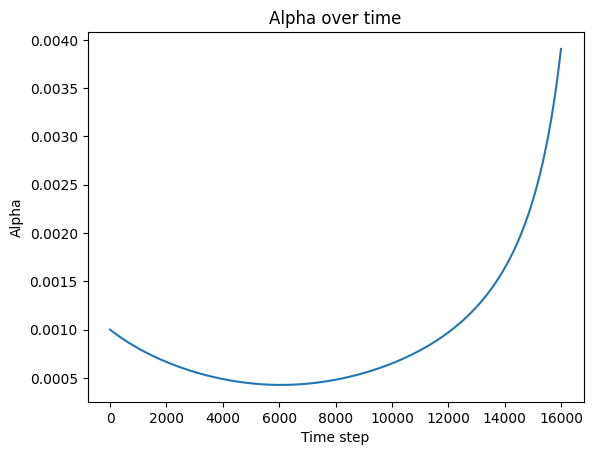

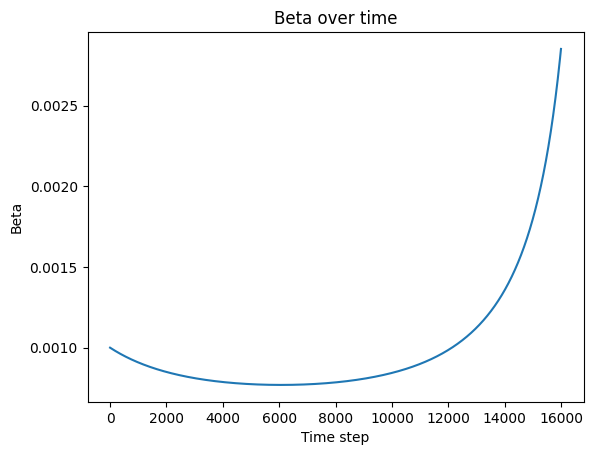

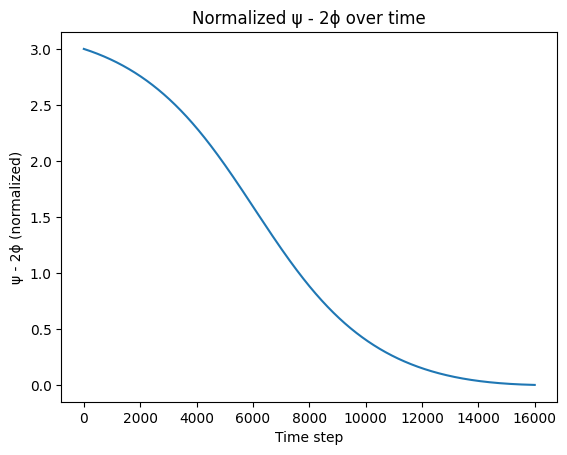

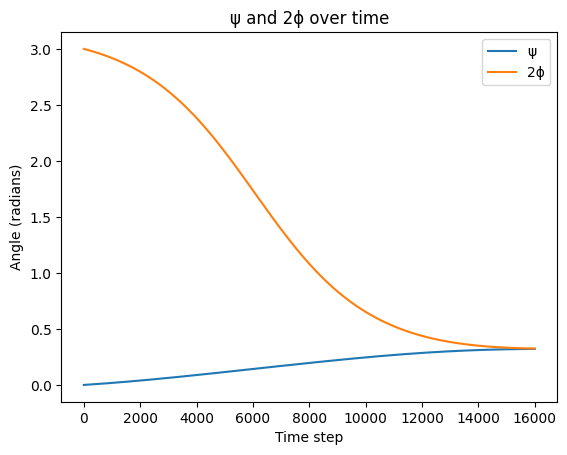

In [3]:
# === Plot 1: Alpha ===
fig, ax = plt.subplots()
ax.plot(alphas)
ax.set_title('Alpha over time')
ax.set_xlabel('Time step')
ax.set_ylabel('Alpha')

# === Plot 2: Beta ===
fig, ax = plt.subplots()
ax.plot(betas)
ax.set_title('Beta over time')
ax.set_xlabel('Time step')
ax.set_ylabel('Beta')

# === Plot 4: Normalized (ψ - 2ϕ) ===
fig, ax = plt.subplots()
ax.plot(deltas)
ax.set_title('Normalized ψ - 2ϕ over time')
ax.set_xlabel('Time step')
ax.set_ylabel('ψ - 2ϕ (normalized)')

# === Plot 5: ψ and 2ϕ ===
fig, ax = plt.subplots()
ax.plot(psis, label='ψ')
ax.plot([phi*2 for phi in phis], label='2ϕ')
ax.set_title('ψ and 2ϕ over time')
ax.set_xlabel('Time step')
ax.set_ylabel('Angle (radians)')
ax.legend()

# # === Plot 5: ψ and 2ϕ ===
# fig, ax = plt.subplots()
# ax.plot(expr, label='2ϕ')
# ax.set_title('ψ and 2ϕ over time')
# ax.set_xlabel('Time step')
# ax.set_ylabel('Angle (radians)')
# ax.legend()

plt.show()

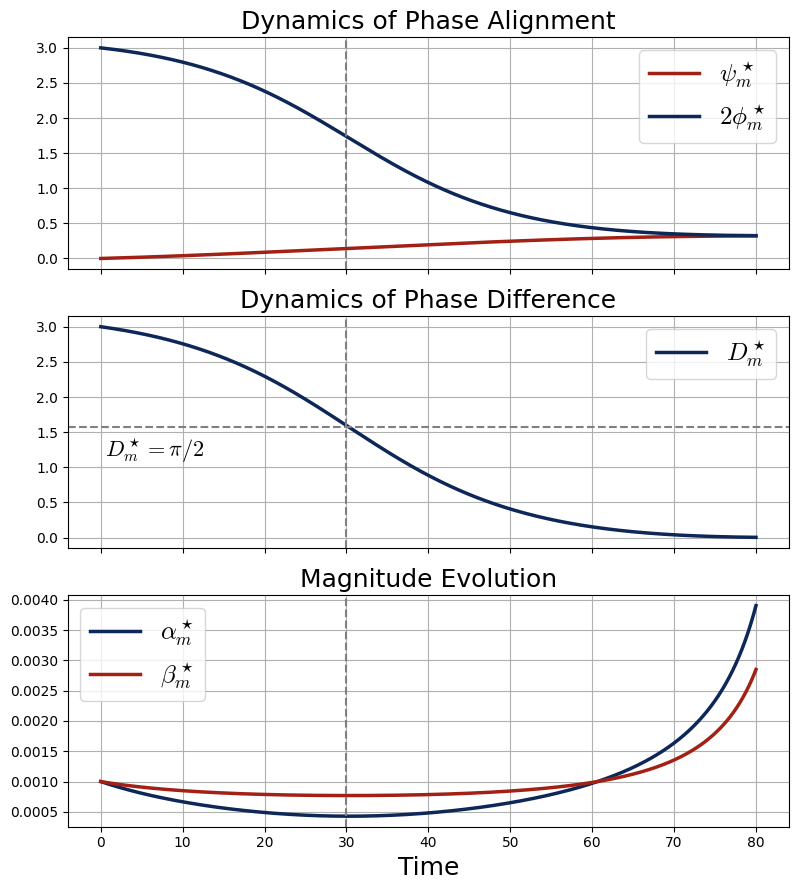

In [4]:
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']
plt.rcParams['mathtext.fontset'] = 'cm'

x = [learning_rate*(step+1) for step in range(num_steps+1)] 
vline_x = 30  # or whatever x-value you want
vline_kwargs = dict(color='gray', linestyle='--', linewidth=1.5)

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

# Plot 1: Phase Input
ax1.plot(x, psis, color=colors[3], linewidth=2.5, label=r"$\psi_m^\star$")
ax1.plot(x, [phi*2 for phi in phis], linewidth=2.5, color=colors[0], label=r"$2\phi_m^\star$")
ax1.axvline(x=vline_x, **vline_kwargs)
ax1.set_title('Dynamics of Phase Alignment', fontsize=18)
ax1.legend(fontsize=18)
ax1.grid(True)

# Plot 2: Output Phase and 2x Input Phase
ax2.plot(x, deltas, color=colors[0], linewidth=2.5, label=r"$D_m^\star$")
ax2.axvline(x=vline_x, **vline_kwargs)
ax2.axhline(y=1.57, **vline_kwargs)  # horizontal line at y=1.57
ax2.text(x=0.5, y=1.15, s=r"$D_m^\star=\pi/2$", fontsize=16, color='black')  # text label
ax2.set_title('Dynamics of Phase Difference', fontsize=18)
ax2.legend(fontsize=18)
ax2.grid(True)

# Plot 3: Scale Magnitudes
ax3.plot(x, alphas, linewidth=2.5, color=colors[0], label=r"$\alpha_m^\star$")
ax3.plot(x, betas, linewidth=2.5, color=colors[3], label=r"$\beta_m^\star$")
ax3.axvline(x=vline_x, **vline_kwargs)
ax3.set_title('Magnitude Evolution', fontsize=18)
ax3.set_xlabel('Time', fontsize=18)
ax3.legend(fontsize=18)
ax3.grid(True)

plt.tight_layout()
#plt.savefig('../figures/phase_align_approx1.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

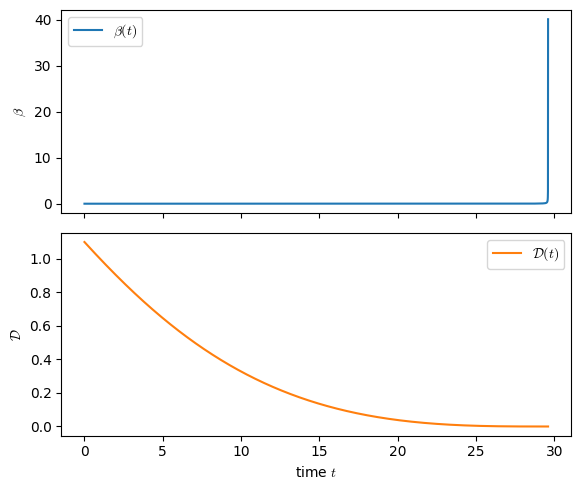

In [26]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def neuron_dynamics(t, y, p, kappa_init):
    beta, D = y
    # dβ/dt = p * (2β^2 – κ_init^2) * cos(D)
    d_beta = p * (2*beta**2 - kappa_init**2) * np.cos(D)
    # dD/dt = -p * (κ_init^2 / β + 2β) * sin(D)
    d_D    = -p * (-kappa_init**2 / beta + 6*beta) * np.sin(D)
    return [d_beta, d_D]

# parameters
p = 23             # scale factor
kappa_init = 0.001     # κ_init
beta0 = kappa_init   # initial β
D0 = 2*0.88-0.66#0.66             # initial phase‐difference
t_span = (0.0, 30) # simulate from t=0 to t=50
t_eval = np.linspace(*t_span, 4000)

# integrate ODE
sol = solve_ivp(
    fun=lambda t, y: neuron_dynamics(t, y, p, kappa_init),
    t_span=t_span,
    y0=[beta0, D0],
    t_eval=t_eval,
    method='RK45',
    atol=1e-8, rtol=1e-6
)

# plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
ax1.plot(sol.t, sol.y[0], label=r'$\beta(t)$')
ax1.set_ylabel(r'$\beta$')
ax1.legend(loc='best')

ax2.plot(sol.t, sol.y[1], label=r'$\mathcal{D}(t)$', color='C1')
ax2.set_xlabel('time $t$')
ax2.set_ylabel(r'$\mathcal{D}$')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()


In [1]:
np.pi/4

NameError: name 'np' is not defined

In [17]:
np.sin(2*0.88-0.58)

0.9246060124080204

In [6]:
# cons = np.sin(sol.y[1]) * (2*sol.y[0]**2-kappa_init**2) / sol.y[0]

# fig, ax = plt.subplots()
# ax.plot(cons)
# ax.set_title('Beta over time')
# ax.set_xlabel('Time step')
# ax.set_ylabel('Beta')

# plt.show()

In [7]:
# — NEW: compute first‐differences of α, β, and δ —
alpha_grad = np.diff(alphas)/learning_rate   
beta_grad  = np.diff(betas)/learning_rate     
delta_grad = np.diff(deltas)/learning_rate 
g_2k_grad = np.diff(g_2ks)/learning_rate
phi_grad  = np.diff(phis)/learning_rate
psi_grad  = np.diff(psis)/learning_rate

cos_phi_grad = np.diff(cos_phis)/learning_rate 
cos_psi_grad = np.diff(cos_psis)/learning_rate 
sin_phi_grad = np.diff(sin_phis)/learning_rate 
sin_psi_grad = np.diff(sin_psis)/learning_rate 

alpha_grad_form = [2 * p * alphas[i] * betas[i] *np.cos(deltas[i]) for i in range(len(alphas))]
beta_grad_form = [p * alphas[i]**2 * np.cos(deltas[i]) for i in range(len(alphas))]
phi_grad_form = [-2 * p * betas[i] * np.sin(deltas[i]) for i in range(len(alphas))]
psi_grad_form = [ p * alphas[i]**2/betas[i] * np.sin(deltas[i]) for i in range(len(alphas))]
delta_grad_form = [-p * (4*betas[i]+alphas[i]**2/betas[i]) * np.sin(deltas[i]) for i in range(len(alphas))]

cos_phi_grad_form = [2 * p * betas[i] * np.sin(phis[i]) * np.sin(deltas[i]) for i in range(len(alphas))]
cos_psi_grad_form = [-p * alphas[i]**2 / betas[i] * np.sin(psis[i]) * np.sin(deltas[i]) for i in range(len(alphas))]

sin_phi_grad_form = [-2 * p * betas[i] * np.cos(phis[i]) * np.sin(deltas[i]) for i in range(len(alphas))]
sin_psi_grad_form = [p * alphas[i]**2 / betas[i] * np.cos(psis[i]) * np.sin(deltas[i]) for i in range(len(alphas))]

g_2k_grad_form = [np.sqrt(2) * p * np.sqrt(p) * alphas[i] * betas[i] * np.cos(psis[i]-phis[i]) for i in range(len(alphas))]

print(g_2k_grad[:10])
print(g_2k_grad_form[:10])

print(alpha_grad[:10])
print(alpha_grad_form[:10])

print(beta_grad[:10])
print(beta_grad_form[:10])

print(cos_phi_grad[:10])
print(cos_phi_grad_form[:10])

print(cos_psi_grad[:10])
print(cos_psi_grad_form[:10])

print(sin_phi_grad[:10])
print(sin_phi_grad_form[:10])

print(sin_psi_grad[:10])
print(sin_psi_grad_form[:10])

print(phi_grad[:10])
print(phi_grad_form[:10])

print(psi_grad[:10])
print(psi_grad_form[:10])

print(delta_grad[:10])
print(delta_grad_form[:10])

[1.10345356e-05 1.10383416e-05 1.10421474e-05 1.10459529e-05
 1.10497581e-05 1.10535631e-05 1.10573677e-05 1.10611721e-05
 1.10649762e-05 1.10687800e-05]
[1.1034545673178971e-05, 1.1038351726464716e-05, 1.104215749963737e-05, 1.1045962993138428e-05, 1.1049768207409003e-05, 1.1053573142890069e-05, 1.105737780002203e-05, 1.1061182179245186e-05, 1.1064986280999455e-05, 1.1068790105724283e-05]
[-4.55395548e-05 -4.55234752e-05 -4.55074038e-05 -4.54913408e-05
 -4.54752859e-05 -4.54592394e-05 -4.54432011e-05 -4.54271711e-05
 -4.54111493e-05 -4.53951358e-05]
[-4.5539657443546054e-05, -4.552357787470398e-05, -4.550750659104378e-05, -4.5491443586220715e-05, -4.54753888538957e-05, -4.545934238773544e-05, -4.544330418141229e-05, -4.542727422860439e-05, -4.5411252522995484e-05, -4.539523905827512e-05]
[-2.27698032e-05 -2.27591717e-05 -2.27485463e-05 -2.27379268e-05
 -2.27273133e-05 -2.27167058e-05 -2.27061042e-05 -2.26955087e-05
 -2.26849191e-05 -2.26743355e-05]
[-2.276982944299759e-05, -2.27591979

In [8]:
#check = [betas[i] * np.sin(deltas[i]) * (4*betas[i]**2 +alphas[i]**2)**(1/3) for i in range(len(alphas))]
check = [np.sin(deltas[i]) * (betas[i] * alphas[i]**2) for i in range(len(alphas))]
check2 = [alphas[i]**2 -  2*betas[i]**2 for i in range(len(alphas))]

check

[1.4112005446485825e-10,
 1.4112003951607041e-10,
 1.4112002457239323e-10,
 1.4112000963382321e-10,
 1.41119994700357e-10,
 1.4111997977199137e-10,
 1.41119964848724e-10,
 1.4111994993055248e-10,
 1.4111993501747302e-10,
 1.4111992010948142e-10,
 1.411199052065769e-10,
 1.4111989030875597e-10,
 1.4111987541601535e-10,
 1.4111986052835197e-10,
 1.4111984564576239e-10,
 1.411198307682454e-10,
 1.4111981589579602e-10,
 1.4111980102841322e-10,
 1.4111978616609202e-10,
 1.4111977130883148e-10,
 1.4111975645662687e-10,
 1.4111974160947725e-10,
 1.4111972676737797e-10,
 1.4111971193032651e-10,
 1.411196970983201e-10,
 1.4111968227135635e-10,
 1.4111966744943178e-10,
 1.4111965263254306e-10,
 1.4111963782068853e-10,
 1.4111962301386432e-10,
 1.4111960821206704e-10,
 1.4111959341529545e-10,
 1.4111957862354555e-10,
 1.4111956383681444e-10,
 1.4111954905509898e-10,
 1.4111953427839637e-10,
 1.4111951950670366e-10,
 1.4111950474001924e-10,
 1.4111948997833896e-10,
 1.4111947522165883e-10,
 1.4111

In [9]:
sin_deltas_check = [np.sin(deltas[0]) * betas[0]**3 / (betas[i] * alphas[i]**2) for i in range(len(alphas))]

print(sin_deltas[-10:])
print(sin_deltas_check[-10:])

[0.00329511 0.00328881 0.00328251 0.00327621 0.00326993 0.00326365
 0.00325739 0.00325113 0.00324487 0.00323863]
[0.0033019923212726844, 0.00329567509289774, 0.0032893659365314525, 0.003283064846979097, 0.0032767718190460826, 0.003270486847537925, 0.0032642099272602604, 0.0032579410530188396, 0.0032516802196195364, 0.003245427421868338]


In [12]:
ls = [np.cos(2*3*np.pi/13*i)**8 for i in range(13)]
print(sum(ls))

from scipy.special import comb
print(13* (1/2**8)*comb(8, 4, exact=True))

3.554687499999998
3.5546875
